# Yelp API - Lab

The previously deployed lab on working around building a GIS with Yelp API and Folium can be found [here](https://github.com/learn-co-curriculum/dsc-2-15-10-yelp-api-gis-lab/tree/a56358c2d0c2daf569a5f50937c4c27463aadb1a) (not relevant for new students).


## Introduction 

Now that we've seen how the Yelp API works, and some basic Folium visualizations its time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system on to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retriving 50 at a time. Processes such as these are often refered to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you, but make the request below.

In [1]:
client_id = "IJWTXgynXG7bzKlgv91pAA"
api_key = "XQPJPrxuD_59q0j5gyw-KoR2qCySAuryTxt9VDrdk7alKNhxN8mPbPIwT3PHvzxD38KG2sfM4k3Bz-A5VtDN2pK5vylAZO_QEGlrJJGbNzDB1l3epXtrtr_qJaiaXHYx"


In [2]:
import requests
import pandas as pd

term = 'Italian'
location = 'NYC'

url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+')
            }
response = requests.get(url, headers=headers, params=url_params)
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"businesses": [{"id": "rp8S7scxOkVVeG7dNneMGQ", "alias": "l-artusi-new-york", "name": "L'Artusi", "image_url": "https://s3-media3.fl.yelpcdn.com/bphoto/Yr4VE25s-pjMnLz9nJvNdQ/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/l-artusi-new-york?adjust_creative=IJWTXgynXG7bzKlgv91pAA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=IJWTXgynXG7bzKlgv91pAA", "review_count": 1653, "categories": [{"alias": "italian", "title": "Italian"}, {"alias": "cocktailbars", "title": "Cocktail Bars"}], "rating": 4.5, "coordinates": {"latitude": 40.733714, "longitude": -74.005068}, "transactions": ["delivery", "pickup"], "price": "$$$", "location": {"address1": "228 W 10th St", "address2": "", "address3": "", "city": "New York", "zip_code": "10014", "country": "US", "state": "NY", "display_address": ["228 W 10th St", "New York, NY 10014"]}, "phone": "+12122555757", "display_phone": "(212) 255-5757", "distance": 3271.9116518313776}, {"id": "IE

In [3]:
len(response.json()['businesses'])

20

In [4]:
response.json()['total']

8100

## Pagination

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.josn().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [5]:
import time

def yelp_api_call(url_params, api_key):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer {}'.format(api_key)}
    response = requests.get(url, headers=headers, params=url_params)
    
    df = pd.DataFrame(response.json()['businesses'])
    return df

def all_results(url_params, api_key):
    num = response.json()['total']
    print('{} total matches found.'.format(num))
    current = 0
    dfs = []
    while current < num and current < 1000:
        url_params['offset'] = current
        dfs.append(yelp_api_call(url_params, api_key))
        time.sleep(1)
        current += 50
    df = pd.concat(dfs, ignore_index=True)
    return df

term = 'Italian'
location = 'NYC'
url_params = {  'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit' : 50
             }
df = all_results(url_params, api_key)
print(len(df))

8100 total matches found.
1000


## Exploratory Analysis

Take the restaurants from the previous question and do an intial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

df.price.unique()

array(['$$$', '$$', '$', '$$$$', nan], dtype=object)

In [7]:
df.columns

Index(['alias', 'categories', 'coordinates', 'display_phone', 'distance', 'id',
       'image_url', 'is_closed', 'location', 'name', 'phone', 'price',
       'rating', 'review_count', 'transactions', 'url'],
      dtype='object')

In [8]:
df.price = df.price.fillna(value = 0)
df.price.unique()

array(['$$$', '$$', '$', '$$$$', 0], dtype=object)

In [9]:
price_dict = {"$": 1, "$$":2, "$$$": 3, "$$$$":4}
df.price = df.price.map(price_dict)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11788ac88>,
      dtype=object)

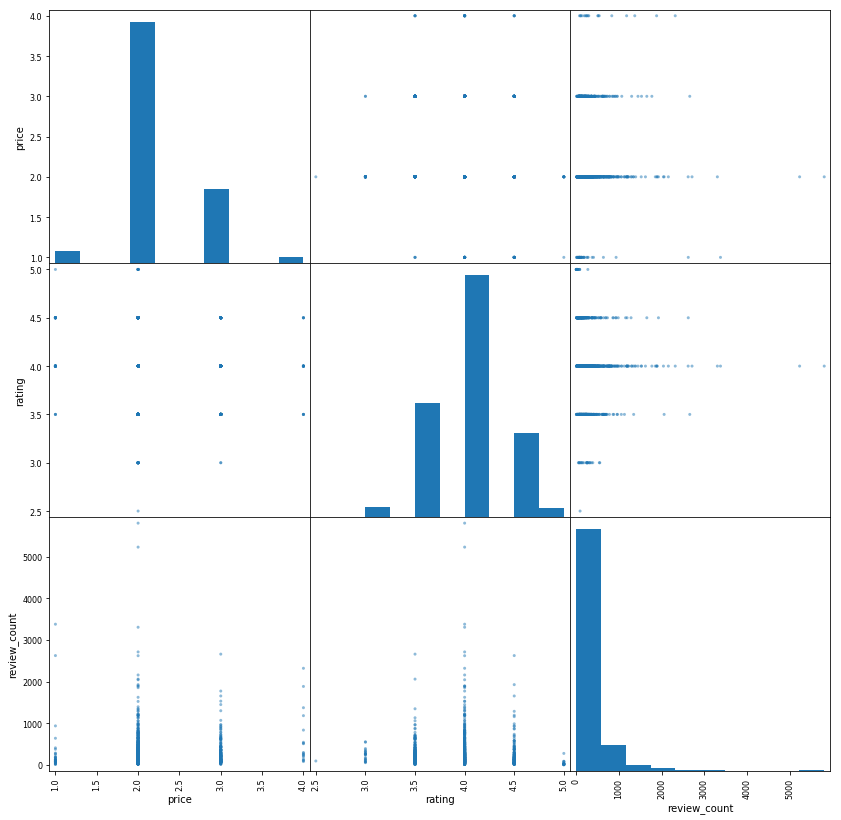

In [15]:
pd.plotting.scatter_matrix(df[['price', 'rating', 'review_count']], figsize=(14, 14))

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [16]:
import folium

lat_long = df['coordinates'].iloc[0]
lat = lat_long['latitude']
long = lat_long['longitude']
yelp_map = folium.Map([lat, long])

for row in df.index:
    try:
        lat_long = df['coordinates'][row]
        lat = lat_long['latitude']
        long = lat_long['longitude']
        name = df['name'][row]
        rating = df['rating'][row]
        price = df['price'][row]
        details = "{}\nPrice: {} Rating:{}".format(name,str(price),str(rating))
        popup = folium.Popup(details, parse_html=True)
        marker = folium.Marker([lat, long], popup=popup)
        marker.add_to(yelp_map)
    except:
        print('Hit error on row: {}'.format(row))
yelp_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!